# ------------------------------
# Data Analysis & Preprocessing for Fraud Detection
# ------------------------------

In [11]:
# Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import ipaddress

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from imblearn.over_sampling import SMOTE

# Display settings for notebook
pd.set_option('display.max_columns', None)

In [4]:
from google.colab import drive
drive.mount('/content/drive')
credit_zip = '/content/drive/MyDrive/FraudPulse/data/raw/creditcard.csv.zip'
!unzip -q "{credit_zip}" -d "/content/drive/MyDrive/FraudPulse/data/raw/"

Mounted at /content/drive


# ------------------------------
# 1️⃣ Load Data
# ------------------------------

In [12]:
# Load data
fraud_df = pd.read_csv('/content/drive/MyDrive/FraudPulse/data/raw/Fraud_Data.csv')
ip_df = pd.read_csv('/content/drive/MyDrive/FraudPulse/data/raw/IpAddress_to_Country.csv')
credit_df = pd.read_csv('/content/drive/MyDrive/FraudPulse/data/raw/creditcard.csv')


print(fraud_df.head())
print(ip_df.head())
print(credit_df.head())

   user_id          signup_time        purchase_time  purchase_value  \
0    22058  2015-02-24 22:55:49  2015-04-18 02:47:11              34   
1   333320  2015-06-07 20:39:50  2015-06-08 01:38:54              16   
2     1359  2015-01-01 18:52:44  2015-01-01 18:52:45              15   
3   150084  2015-04-28 21:13:25  2015-05-04 13:54:50              44   
4   221365  2015-07-21 07:09:52  2015-09-09 18:40:53              39   

       device_id source browser sex  age    ip_address  class  
0  QVPSPJUOCKZAR    SEO  Chrome   M   39  7.327584e+08      0  
1  EOGFQPIZPYXFZ    Ads  Chrome   F   53  3.503114e+08      0  
2  YSSKYOSJHPPLJ    SEO   Opera   M   53  2.621474e+09      1  
3  ATGTXKYKUDUQN    SEO  Safari   M   41  3.840542e+09      0  
4  NAUITBZFJKHWW    Ads  Safari   M   45  4.155831e+08      0  
   lower_bound_ip_address  upper_bound_ip_address    country
0              16777216.0                16777471  Australia
1              16777472.0                16777727      China


# ------------------------------
# 2️⃣ Handle Missing Values
# ------------------------------

In [13]:
print(fraud_df.isnull().sum())

# If you find missing age: you might fill with median
fraud_df['age'] = fraud_df['age'].fillna(fraud_df['age'].median())

# Or drop rows if the column is not critical
fraud_df.dropna(subset=['purchase_value'], inplace=True)

user_id           0
signup_time       0
purchase_time     0
purchase_value    0
device_id         0
source            0
browser           0
sex               0
age               0
ip_address        0
class             0
dtype: int64



# ------------------------------
# 3️⃣ Data Cleaning
# ------------------------------


In [ ]:
# Remove duplicates
fraud_df.drop_duplicates(inplace=True)
credit_df.drop_duplicates(inplace=True)

# Correct data types
fraud_df['signup_time'] = pd.to_datetime(fraud_df['signup_time'])
fraud_df['purchase_time'] = pd.to_datetime(fraud_df['purchase_time'])
fraud_df['age'] = pd.to_numeric(fraud_df['age'], errors='coerce')

# ------------------------------
# 4️⃣ Univariate EDA
# ------------------------------

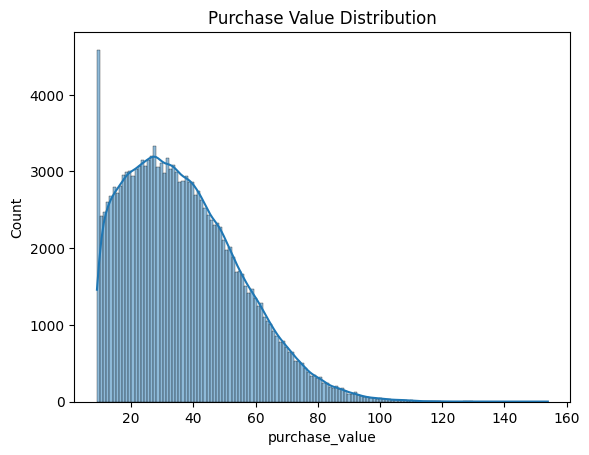

count    151112.000000
mean         36.935372
std          18.322762
min           9.000000
25%          22.000000
50%          35.000000
75%          49.000000
max         154.000000
Name: purchase_value, dtype: float64


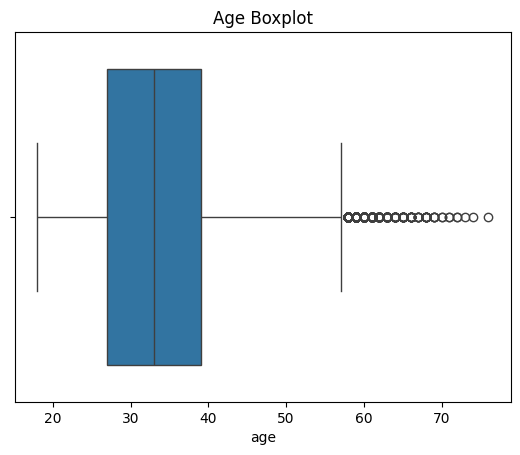

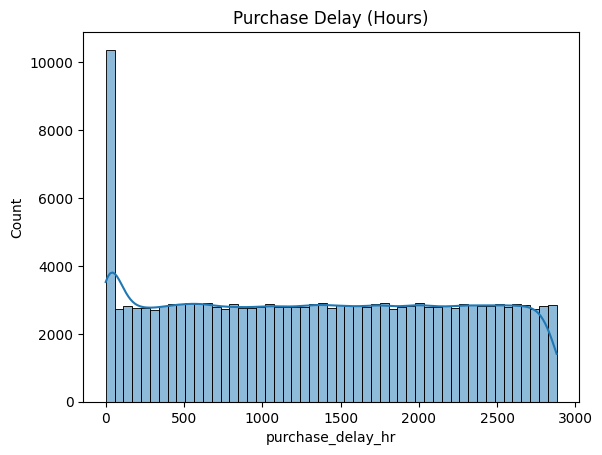

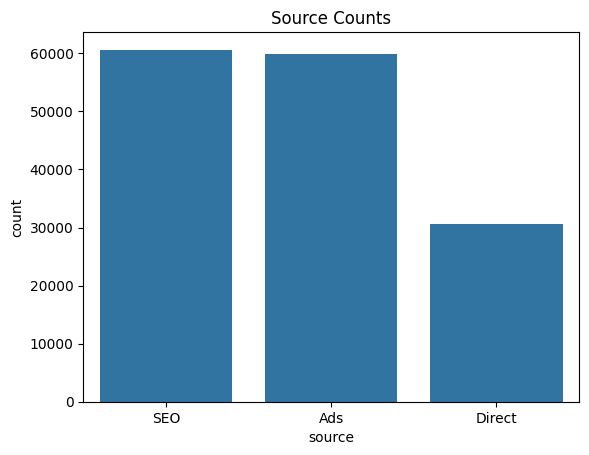

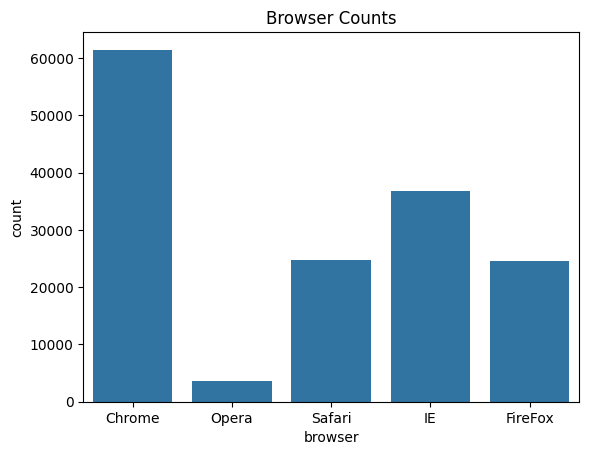

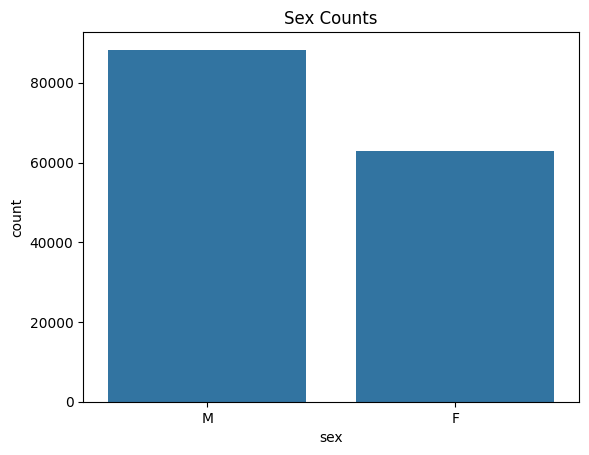

Unique devices: 137956
Unique IPs: 143512


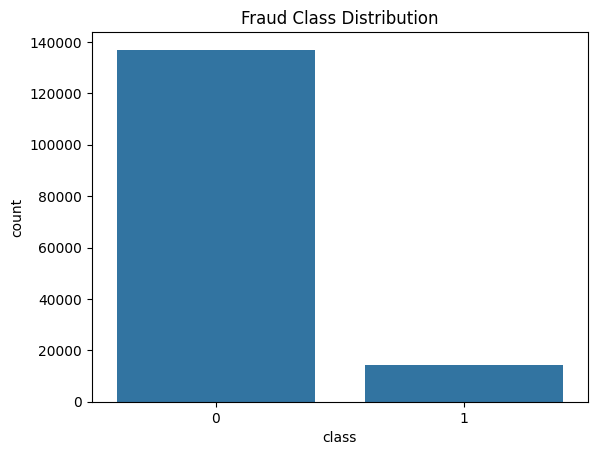

class
0    0.906354
1    0.093646
Name: proportion, dtype: float64


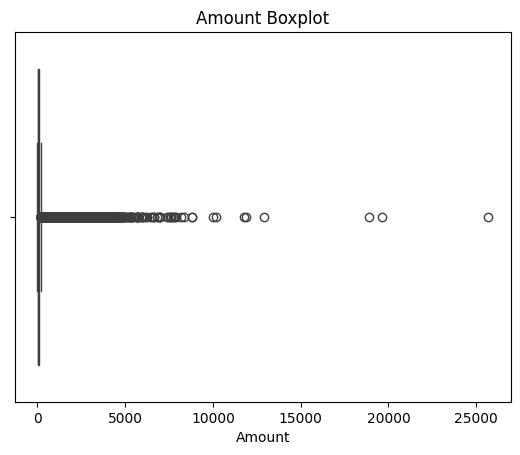

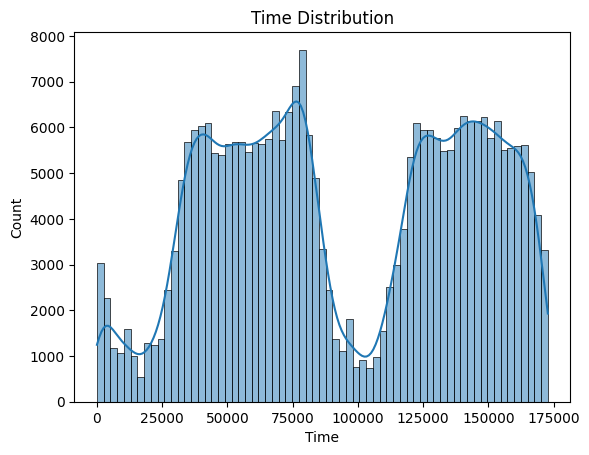

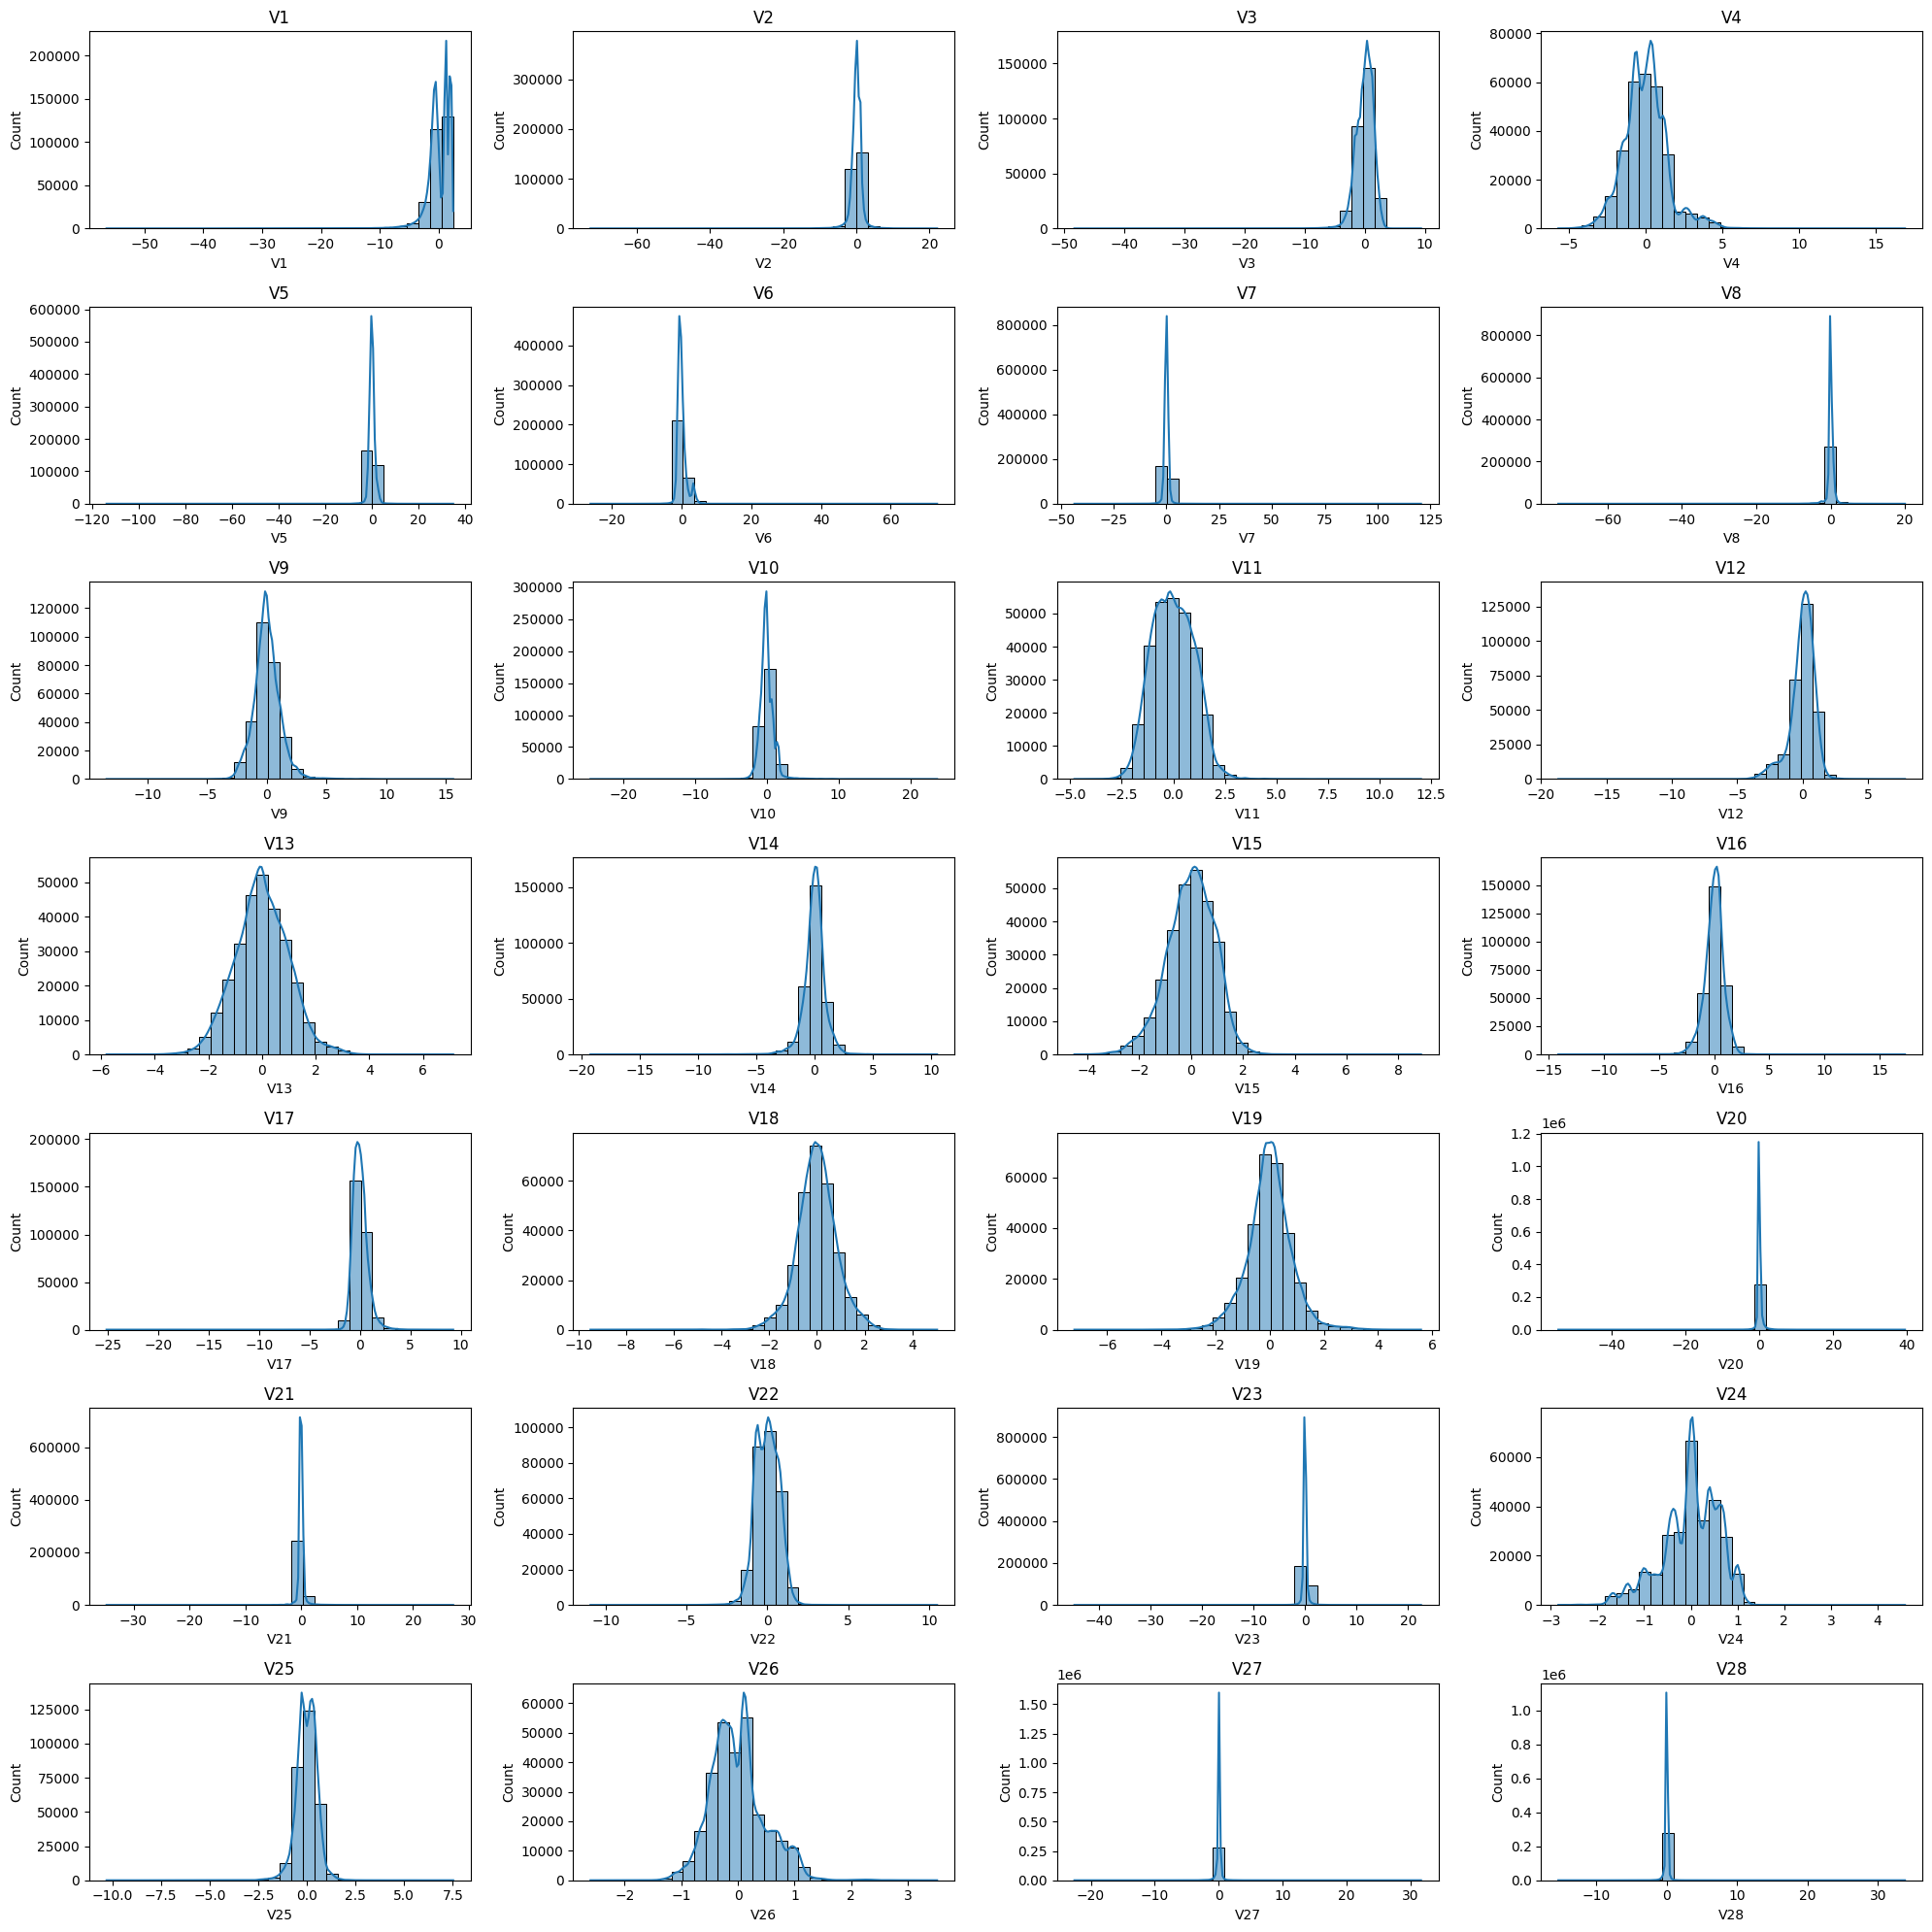

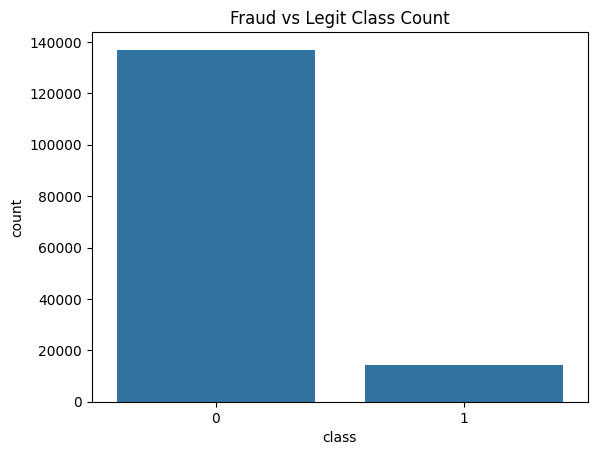

In [18]:
# Numeric
sns.histplot(fraud_df['purchase_value'], kde=True)
plt.title("Purchase Value Distribution")
plt.show()
print(fraud_df['purchase_value'].describe())

sns.boxplot(x=fraud_df['age'])
plt.title("Age Boxplot")
plt.show()

# purchase_delay
# Ensure the columns are datetime objects before calculation
fraud_df['signup_time'] = pd.to_datetime(fraud_df['signup_time'])
fraud_df['purchase_time'] = pd.to_datetime(fraud_df['purchase_time'])

fraud_df['purchase_delay_hr'] = (fraud_df['purchase_time'] - fraud_df['signup_time']).dt.total_seconds() / 3600
sns.histplot(fraud_df['purchase_delay_hr'], kde=True)
plt.title("Purchase Delay (Hours)")
plt.show()

# Categorical
# source
sns.countplot(x='source', data=fraud_df)
plt.title("Source Counts")
plt.show()

# browser
sns.countplot(x='browser', data=fraud_df)
plt.title("Browser Counts")
plt.show()

# sex
sns.countplot(x='sex', data=fraud_df)
plt.title("Sex Counts")
plt.show()

# device_id unique
print(f"Unique devices: {fraud_df['device_id'].nunique()}")

# ip_address unique
print(f"Unique IPs: {fraud_df['ip_address'].nunique()}")

# Target imbalance
sns.countplot(x='class', data=fraud_df)
plt.title("Fraud Class Distribution")
plt.show()

print(fraud_df['class'].value_counts(normalize=True))


# ✅ creditcard.csv
sns.boxplot(x=credit_df['Amount'])
plt.title("Amount Boxplot")
plt.show()


sns.histplot(credit_df['Time'], kde=True)
plt.title("Time Distribution")
plt.show()


# Set up the grid
plt.figure(figsize=(20, 20))
for i, col in enumerate([f"V{i}" for i in range(1, 29)]):
    plt.subplot(7, 4, i+1)  # 7 rows, 4 columns
    sns.histplot(credit_df[col], kde=True, bins=30)
    plt.title(col)
plt.tight_layout()
plt.show()


sns.countplot(data=fraud_df, x='class')
plt.title("Fraud vs Legit Class Count")
plt.show()

# ------------------------------
# 5️⃣ Bivariate EDA
# ------------------------------

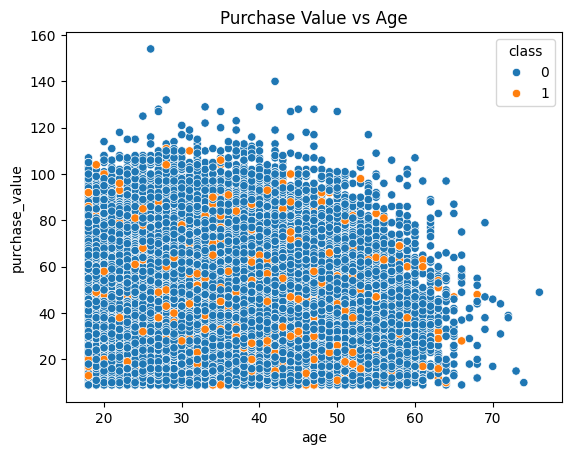

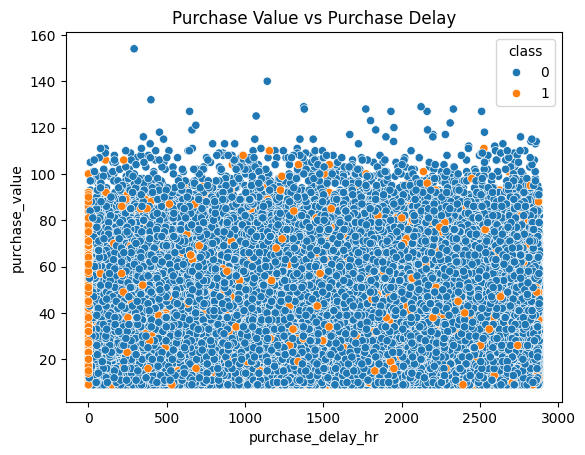

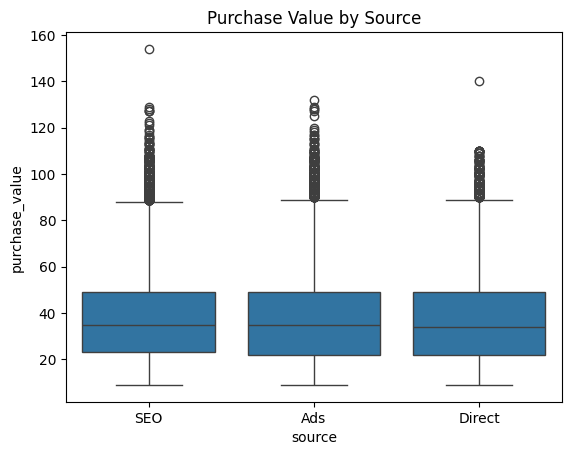

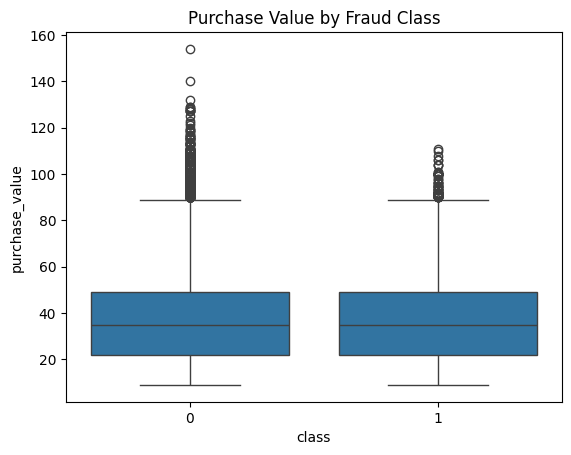

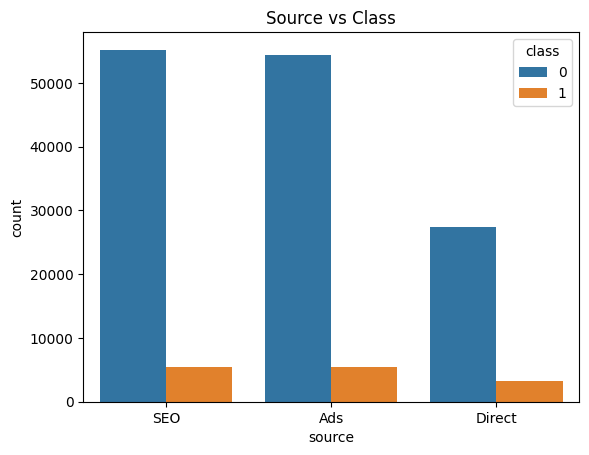

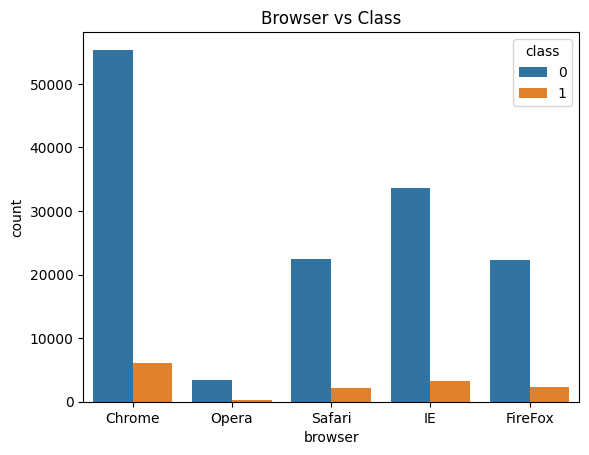

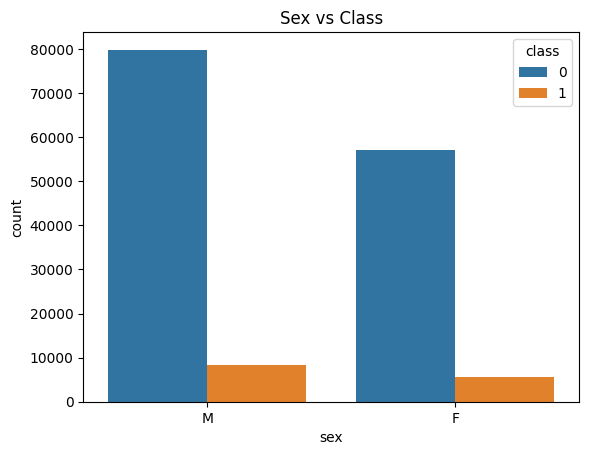

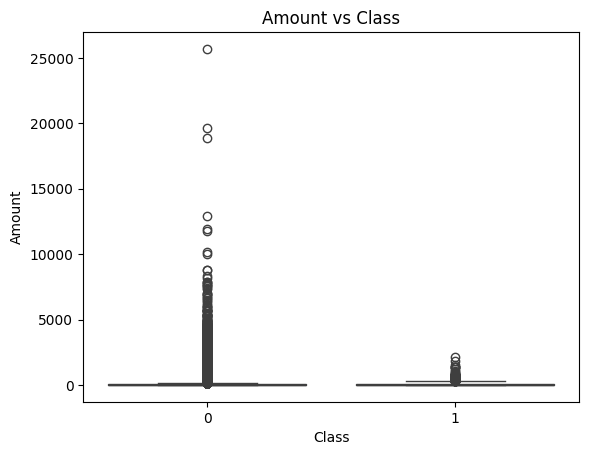

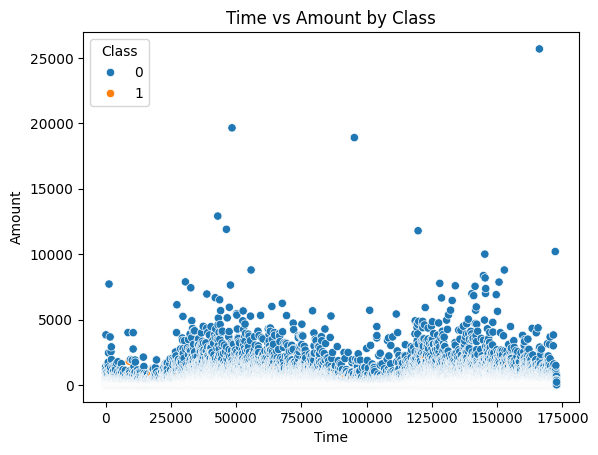

In [19]:
# purchase_value vs age
sns.scatterplot(x='age', y='purchase_value', hue='class', data=fraud_df)
plt.title("Purchase Value vs Age")
plt.show()

# purchase_delay vs purchase_value
sns.scatterplot(x='purchase_delay_hr', y='purchase_value', hue='class', data=fraud_df)
plt.title("Purchase Value vs Purchase Delay")
plt.show()

# purchase_value by source
sns.boxplot(x='source', y='purchase_value', data=fraud_df)
plt.title("Purchase Value by Source")
plt.show()

# purchase_value by class
sns.boxplot(x='class', y='purchase_value', data=fraud_df)
plt.title("Purchase Value by Fraud Class")
plt.show()

# source vs class
sns.countplot(x='source', hue='class', data=fraud_df)
plt.title("Source vs Class")
plt.show()

# browser vs class
sns.countplot(x='browser', hue='class', data=fraud_df)
plt.title("Browser vs Class")
plt.show()

# sex vs class
sns.countplot(x='sex', hue='class', data=fraud_df)
plt.title("Sex vs Class")
plt.show()

# creditcard Amount vs Class
sns.boxplot(x='Class', y='Amount', data=credit_df)
plt.title("Amount vs Class")
plt.show()

# Time vs Class
sns.scatterplot(x='Time', y='Amount', hue='Class', data=credit_df)
plt.title("Time vs Amount by Class")
plt.show()


# ------------------------------
# 6️⃣ Merge Datasets for IP
# ------------------------------

          ip_address        country
116708  8.802175e+08  United States
15108   2.785906e+09    Switzerland
46047   3.560567e+08  United States
67650   7.591047e+08        Unknown
109067  2.985180e+09         Mexico


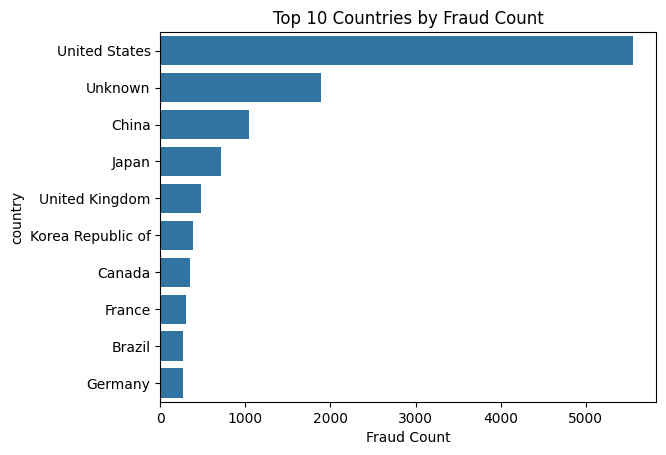

In [23]:
def find_country(ip, ip_df):
    # Ensure ip_df has the numerical columns
    if 'lower_bound_ip_address' not in ip_df.columns or 'upper_bound_ip_address' not in ip_df.columns:
         raise ValueError("ip_df must have 'lower_bound_ip_address' and 'upper_bound_ip_address' columns")

    # Find the country for the given IP address
    match = ip_df[(ip_df['lower_bound_ip_address'] <= ip) & (ip_df['upper_bound_ip_address'] >= ip)]
    if not match.empty:
        return match.iloc[0]['country']
    else:
        return 'Unknown'

# Apply the function to create the 'country' column
# Assuming 'ip_address' in fraud_df is already a numerical representation
fraud_df['country'] = fraud_df['ip_address'].apply(lambda x: find_country(x, ip_df))

print(fraud_df[['ip_address', 'country']].head())
# Top Fraud Countries
top_countries = fraud_df[fraud_df['class'] == 1]['country'].value_counts().head(10)
sns.barplot(y=top_countries.index, x=top_countries.values)
plt.title("Top 10 Countries by Fraud Count")
plt.xlabel("Fraud Count")
plt.show()

# ------------------------------
# 7️⃣ Feature Engineering
# ------------------------------

In [22]:
# Sort
fraud_df = fraud_df.sort_values(by=['user_id', 'purchase_time'])

# Previous purchase time
fraud_df['prev_purchase'] = fraud_df.groupby('user_id')['purchase_time'].shift(1)
fraud_df['time_diff_hr'] = (fraud_df['purchase_time'] - fraud_df['prev_purchase']).dt.total_seconds() / 3600
fraud_df['txn_count'] = fraud_df.groupby('user_id').cumcount() + 1
fraud_df['account_age_hr'] = (fraud_df['purchase_time'] - fraud_df['signup_time']).dt.total_seconds() / 3600
fraud_df['velocity'] = fraud_df['txn_count'] / (fraud_df['account_age_hr'] + 1)

fraud_df['hour_of_day'] = fraud_df['purchase_time'].dt.hour
fraud_df['day_of_week'] = fraud_df['purchase_time'].dt.dayofweek
fraud_df['time_since_signup_hr'] = (fraud_df['purchase_time'] - fraud_df['signup_time']).dt.total_seconds() / 3600

print(fraud_df[['user_id', 'velocity', 'hour_of_day', 'day_of_week']].head())

        user_id  velocity  hour_of_day  day_of_week
116708        2  0.001009           10            5
15108         4  0.000358           21            5
46047         8  0.000540           11            3
67650         9  0.009603           23            2
109067       12  0.000777           20            2



# ------------------------------
# 8️⃣ Data Transformation
# ------------------------------

In [27]:
X = fraud_df[['purchase_value', 'age', 'purchase_delay_hr', 'time_diff_hr', 'velocity', 'hour_of_day', 'day_of_week', 'time_since_signup_hr']]
X = X.fillna(0)
y = fraud_df['class']

# Separate categorical features before splitting
X_cat = fraud_df[['source', 'browser', 'sex']]

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_train_cat, X_test_cat, _, _ = train_test_split(X_cat, y, test_size=0.3, stratify=y, random_state=42)


# SMOTE
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)

# One-Hot Encoding for categoricals
encoder = OneHotEncoder(handle_unknown='ignore') # Handle potential new categories in test set
X_train_cat_encoded = encoder.fit_transform(X_train_cat).toarray()
X_test_cat_encoded = encoder.transform(X_test_cat).toarray()

# Apply SMOTE to categorical features
X_train_cat_res, _ = smote.fit_resample(X_train_cat_encoded, y_train) # Apply SMOTE to encoded categorical features

X_train_final = np.hstack([X_train_scaled, X_train_cat_res]) # Concatenate with resampled categorical features
X_test_final = np.hstack([X_test_scaled, X_test_cat_encoded])


print("Data ready for modeling!")

Data ready for modeling!


# ------------------------------
#  Final: Save Processed Data
# ------------------------------

In [28]:
# 1️⃣ Make sure arrays → DataFrames
X_train_final_df = pd.DataFrame(X_train_final)
X_test_final_df = pd.DataFrame(X_test_final)

y_train_res_df = pd.DataFrame(y_train_res, columns=['class']).reset_index(drop=True)
y_test_df = pd.DataFrame(y_test, columns=['class']).reset_index(drop=True)

# 2️⃣ Combine X and y
train_ready = pd.concat([X_train_final_df, y_train_res_df], axis=1)
test_ready = pd.concat([X_test_final_df, y_test_df], axis=1)

# 3️⃣ Save to CSV
train_ready.to_csv("/content/drive/MyDrive/FraudPulse/data/processed/train_ready.csv", index=False)
test_ready.to_csv("/content/drive/MyDrive/FraudPulse/data/processed/test_ready.csv", index=False)

print("Processed training & test data saved as CSV!")

Processed training & test data saved as CSV!
